In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader #handling data in batches
import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
#Loaded the dataset and seperated target variable from other feature
df = pd.read_csv("/content/gdrive/My Drive/migraine_data.csv")
df.drop(columns=["DPF"], inplace=True)
target = df["Type"]
features = df.drop(columns=["Type"])

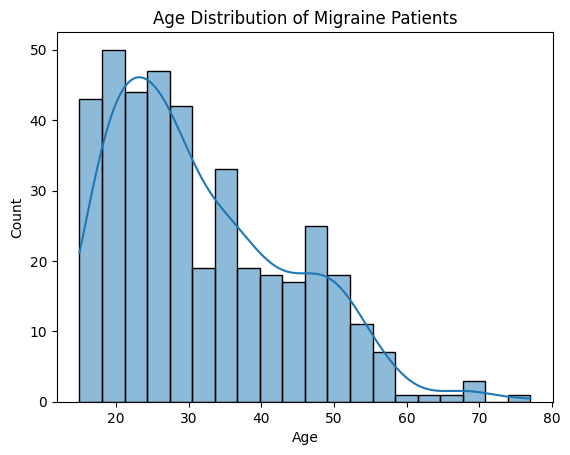

In [18]:
# Age distribution graph
sns.histplot(df["Age"], bins=20, kde=True)
plt.title("Age Distribution of Migraine Patients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


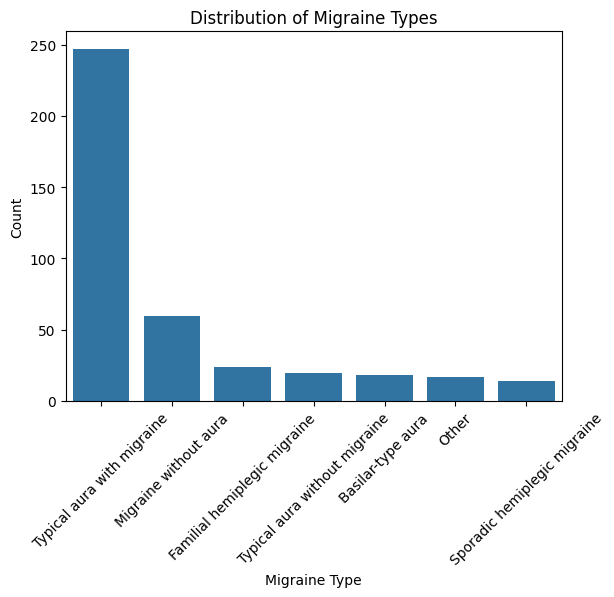

In [19]:
#count types of migraine
sns.countplot(data=df, x="Type", order=df["Type"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Migraine Types")
plt.xlabel("Migraine Type")
plt.ylabel("Count")
plt.show()

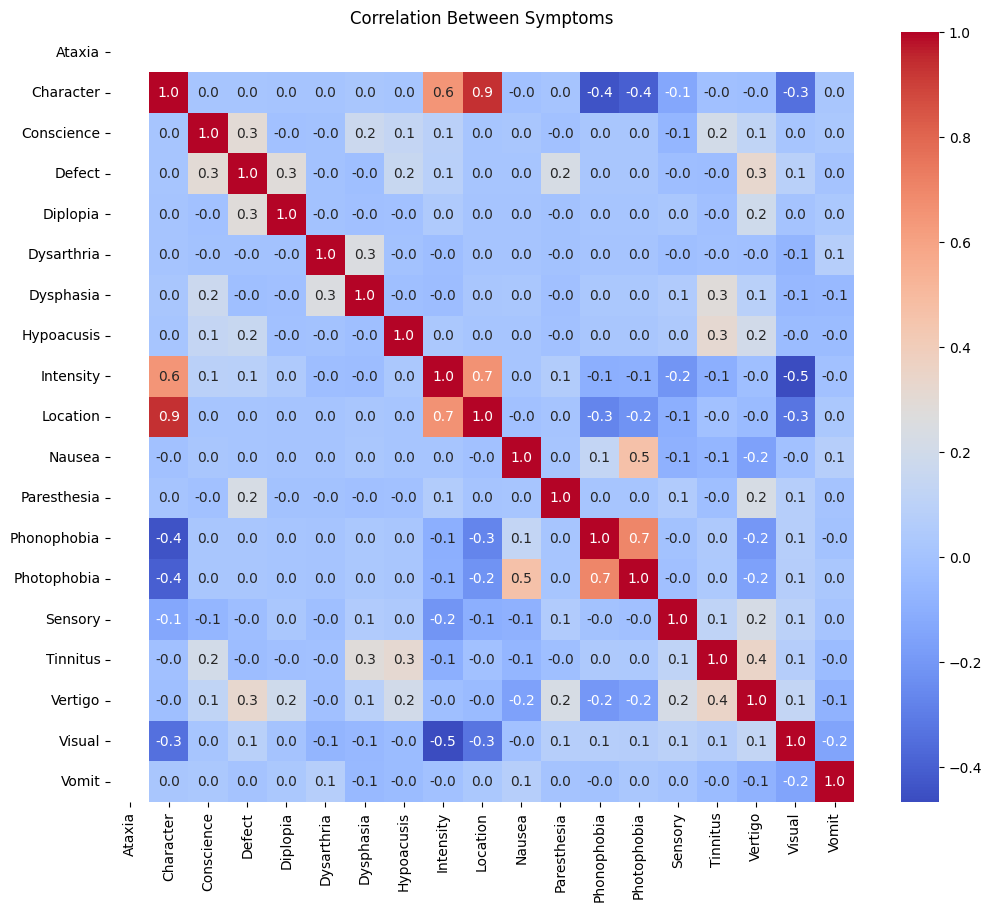

In [20]:
#symptom correlation heatmap
symptom_cols = df.columns.difference(["Age", "Duration", "Frequency", "Type"])
corr = df[symptom_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Correlation Between Symptoms")
plt.show()

In [7]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(target)

scaler = StandardScaler()
X = scaler.fit_transform(features)

In [8]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


In [10]:
# STEP 3: Custom dataset
class MigraineDataset(Dataset):
    def __init__(self, X, y): #Stores thefeatures X and labels y
        self.X = X
        self.y = y
    def __len__(self):  #len returns the number of samples
        return len(self.X)
    def __getitem__(self, idx): #retrieves a single item and with its label by index
        return self.X[idx], self.y[idx]

#helps with easy data loading and managing in batches helps with efficient in training neural networks
train_loader = DataLoader(MigraineDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(MigraineDataset(X_test, y_test), batch_size=16)

In [11]:
# STEP 4: Define the model
class MigrainePredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MigrainePredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64) #input layer = takes number of inputs
        self.fc2 = nn.Linear(64, 32) #two fully connected layers with 64, 32 neurons, followed by ReLU Activation function (learns non-linear patterns)
        self.fc3 = nn.Linear(32, output_dim) #produces output (predictions), 32 = no.of classes in target variable

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # logits

input_dim = X.shape[1]
output_dim = len(set(y))
model = MigrainePredictor(input_dim, output_dim)


In [12]:
# STEP 5: Training setup
criterion = nn.CrossEntropyLoss() #multiclass classification, measures difference between predicited and true labels, measures each class
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #Adam = learning rate, effective and fast in training neural networks


In [13]:
# STEP 6: Train the model
for epoch in range(10):
    for X_batch, y_batch in train_loader: #split the training data into mini chunks
     # X_batch = input features, y_batch = labels
        optimizer.zero_grad() #reset the gradient to zero to prevent accumulation of gradients from previous steps
        outputs = model(X_batch) #forward pass (takes input data and predicts output for each migraine type)
        loss = criterion(outputs, y_batch) #computing the difference between the actual and predicted values
        loss.backward() #backpropagation (calculating how much each weight contributed to the error/loss and updates it)
        optimizer.step() #updates the weights
    print(f"Epoch {epoch+1} | Loss: {loss.item():.2f}")


Epoch 1 | Loss: 1.7547
Epoch 2 | Loss: 1.4003
Epoch 3 | Loss: 1.0320
Epoch 4 | Loss: 0.5710
Epoch 5 | Loss: 1.1897
Epoch 6 | Loss: 0.8602
Epoch 7 | Loss: 0.4791
Epoch 8 | Loss: 0.4330
Epoch 9 | Loss: 0.7308
Epoch 10 | Loss: 0.4528


In [16]:
# STEP 7: Evaluate the model
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"\nAccuracy: {100 * correct / total:.2f}%")


Accuracy: 91.25%


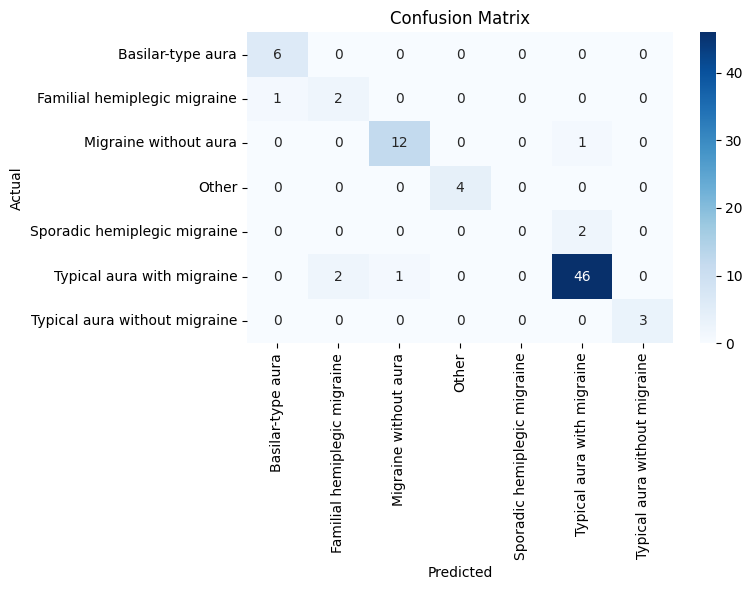

                               precision    recall  f1-score   support

            Basilar-type aura       0.86      1.00      0.92         6
 Familial hemiplegic migraine       0.50      0.67      0.57         3
        Migraine without aura       0.92      0.92      0.92        13
                        Other       1.00      1.00      1.00         4
 Sporadic hemiplegic migraine       0.00      0.00      0.00         2
   Typical aura with migraine       0.94      0.94      0.94        49
Typical aura without migraine       1.00      1.00      1.00         3

                     accuracy                           0.91        80
                    macro avg       0.75      0.79      0.77        80
                 weighted avg       0.90      0.91      0.90        80



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Switch model to evaluation mode
model.eval()

# Collect predictions
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(y_batch.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=labels))
